In [1]:
from functools import partial
import math

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import Tensor
import torch.nn as nn
import torch.utils.data as data

import pyro
import pyro.distributions as dist
import pyro.infer.autoguide as ag

import tyxe

from contbayes.BayesNN import FullCovBNN
from contbayes.EKF import EKF

# Bayesian Continual Learning - Classification Example

Consider a $\pi/4$-QPSK constellation in 2D. QPSK constellation can be seen in the figure below in blue and the $\pi/4$-QPSK constellation (rotated $45^{\circ}$ degrees clockwise) can be seen in green.

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Pi-by-4-QPSK_Gray_Coded.svg/1280px-Pi-by-4-QPSK_Gray_Coded.svg.png" width="400"/>
</div>

We have four constellation points, $\sqrt{E_s}\text{exp}\left(j\frac{\pi(k + 2)}{2} \right)$ for $k=0,1,2,3$ representing `00`, `01`, `10` and `11`.

We will assume additive white gaussian noise with zero mean - $\mathcal{N}\left(\boldsymbol{0}, \frac{1}{2}N_0\boldsymbol{I}_2\right)$.

The lower bound on the error rate, achieved by the MAP rule, is
$$P_e \geq 1 - \left(1 - Q\left(\sqrt{\frac{2E_s}{N_0}}\right)\right)^2 = 1 - \left(1 - Q\left(\sqrt{SNR}\right)\right)^2$$
where $Q$ is the Q-function and the SNR is defined by
$$SNR = \frac{E_s}{\frac{1}{2}N_0} = \frac{2E_s}{N_0}$$

We'll choose $E_s = 2$ and $N_0 = 1/4$ giving $\text{SNR} = 16$.

The lower bound on the error is
$$P_e \geq 1 - (1 - Q(4))^2 = 6.334\text{e-5}$$

In [2]:
N_0 = 1/4
Es = 2

In [3]:
def test_model(model, inputs, labels):

    # Initialize lists to store true labels and predictions
    true_labels = []
    pred_labels = []
    probabilities = []

    # Run predictions
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        # Get the class with the highest probability (use mode of the predictive distribution)
        output = model.predict(inputs, num_predictions = 32)
        probabilities.extend(output.max(-1).values.tolist())
        true_labels.extend(labels.squeeze().tolist())  # Remove any extraneous dimensions
        pred_labels.extend(output.argmax(-1).tolist())

    # Calculate accuracy
    accuracy = sum(1 for true, pred in zip(true_labels, pred_labels) if true == pred) / len(true_labels)

    # Calculate confidence
    confidence = sum(probabilities) / len(probabilities)

    return [accuracy, confidence]

def plot_decision_zones(model, inputs, labels, num_points):
    # Plot decision zones
    x_min, x_max = inputs[:, 0].min() - 0.1, inputs[:, 0].max() + 0.1
    y_min, y_max = inputs[:, 1].min() - 0.1, inputs[:, 1].max() + 0.1
    grid_size = max(abs(x_min), abs(y_min), abs(x_max), abs(y_max))
    xx, yy = np.meshgrid(np.arange(-grid_size, grid_size, 0.01),
                        np.arange(-grid_size, grid_size, 0.01))


    # Predict each point on the mesh (grid)
    grid_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    with torch.no_grad():
        grid_predictions = model.predict(grid_tensor, num_predictions = 32).argmax(-1).reshape(xx.shape)

    # Plot the decision boundary
    contour_colors = ["#1f77b4", "#1f77b4", "#ff7f0e", "#ff7f0e", "#2ca02c", "#2ca02c", "#d62728", "#d62728"]
    plt.contourf(xx, yy, grid_predictions.numpy(), alpha=0.7, colors = contour_colors[:2*num_points])
    scatter_colors = ["blue", "orange", "green", "red"]
    plt.scatter(inputs[..., 0], inputs[... , 1], edgecolors = "k", s = 20, c = [scatter_colors[int(l)] for l in labels])
    plt.title("Decision zones")
    plt.xlabel('In Phase Component')
    plt.ylabel('Quadrature Component')
    plt.xlim([-grid_size, grid_size])
    plt.ylim([-grid_size, grid_size])
    plt.show()

In [4]:
class ConstellationCircleDynamics:
    def __init__(self, n_points: int, noise_var:float, speed: float, energy: float, archive_path = True):
        self.n_points = n_points
        self.points = math.sqrt(energy) * torch.tensor([[math.cos(2 * math.pi * k / n_points + math.pi), math.sin(2 * math.pi * k / n_points + math.pi)] for k in range(n_points)])
        self.noise_var = noise_var
        self.speed = speed
        self.energy = energy
        self.time = 0
        self.archive_path = archive_path
        self.points_archive = self.points.unsqueeze(0)

    def generate_samples(self, n: int = 1, advance: bool = True, randomize_order: bool = False) -> tuple[Tensor, Tensor]:
        """
        :param n: number of samples to generate
        :param advance: advances the model to the next time step if True
        :param randomize_order: randomizes the order of the points sampled if True
        :return samples (n, 2): n / n_points samples from each constellation point
        """

        samples = math.sqrt(self.noise_var) * torch.randn(n, 2)

        if randomize_order:
            labels = torch.tensor(np.random.choice(a = self.n_points, size = n))
        else:
            labels = (torch.arange(n) * self.n_points) // n

        samples += self.points[labels]

        if advance:
            self.advance()

        return samples, labels

    def advance(self):
        self.time += 1
        self.points = math.sqrt(self.energy) * torch.tensor([[math.cos(2 * math.pi *  (k + self.speed * self.time) / self.n_points + math.pi), math.sin(2 * math.pi * (k + self.speed * self.time) / self.n_points + math.pi)] for k in range(self.n_points)])
        if self.archive_path:
            self.points_archive = torch.cat([self.points_archive, self.points.unsqueeze(0)])

In [5]:
num_examples = 1000
dyn = ConstellationCircleDynamics(n_points = 4, noise_var = N_0 / 2, speed = 1e-4, energy = Es)
x, y = dyn.generate_samples(4 * num_examples, advance=False)
dataset = data.TensorDataset(x, y)
loader = data.DataLoader(dataset, batch_size = len(x) // 5)

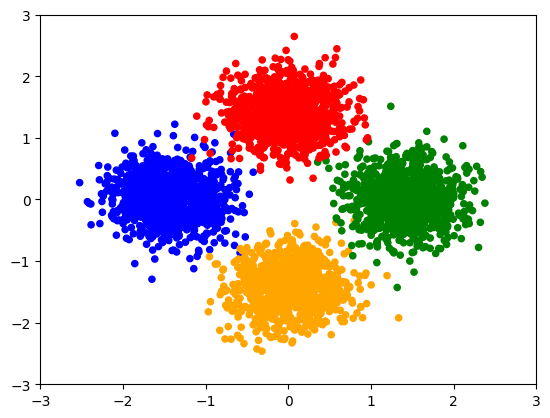

In [6]:
colors = ["blue", "orange", "green", "red"]
plt.scatter(x[..., 0], x[..., 1], s = 20, c = [colors[int(l)] for l in y])
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

In [7]:
loc = scale = scale_tril = None
assert loc is None
assert scale is None
assert scale_tril is None
trained = False

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # self.fc1 = nn.Linear(2, 2)
        # self.activation = nn.Tanh()
        self.fc2 = nn.Linear(2, 4)
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, inputs):
        # temp = self.activation(self.fc1(inputs))
        outputs = self.softmax(self.fc2(inputs))
        return outputs

net = Net()
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
obs_model = tyxe.likelihoods.Categorical(dataset_size = len(loader.dataset), logit_predictions = False)
guide = partial(ag.AutoMultivariateNormal,
                init_scale=1e-4
)

BayesNN = FullCovBNN(model_type = "classifier",
                 output_dim = 4,
                 net_builder = Net,
                 prior = prior,
                 likelihood = obs_model,
                 guide_builder = guide)

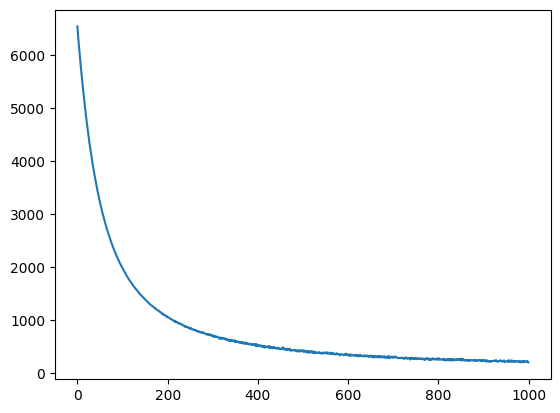

In [9]:
if trained:
    BayesNN.predict(x[0])
    BayesNN.set_loc(loc)
    BayesNN.set_scale(scale)
    BayesNN.set_tril(scale_tril)
else:
    pyro.clear_param_store()
    param_store = pyro.get_param_store()
    optim = pyro.optim.Adam({"lr": 4e-3})
    elbos = []
    def callback(bnn, i, e):
        elbos.append(e)

    BayesNN.fit(loader, optim, 1000, callback)

    plt.plot(elbos)
    plt.show()

    loc = param_store.get_param('net_guide.loc').detach().clone()
    scale = param_store.get_param('net_guide.scale').detach().clone()
    scale_tril = param_store.get_param('net_guide.scale_tril').detach().clone()
    trained = True

Accuracy: 0.9945
Confidence: 0.9656


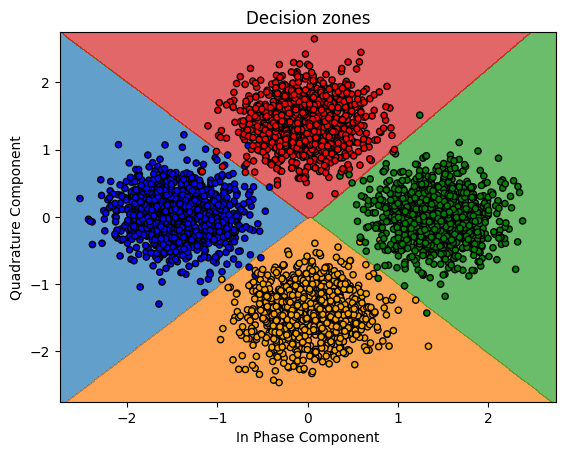

In [10]:
acc, conf = test_model(BayesNN, x, y)
print(f"Accuracy: {acc:.4f}")
print(f"Confidence: {conf:.4f}")
plot_decision_zones(BayesNN, x, y, 4)

In [11]:
Kalman_Filter = EKF(obs_model = BayesNN, state_model = 1, process_noise_var = 0)
dyn = ConstellationCircleDynamics(n_points = 4, noise_var = N_0 / 2, speed = 1e-4, energy = Es)

Kalman_Filter.run(obs_generator = partial(dyn.generate_samples, randomize_order = False) , num_iterations = 10000, n_obs = 32, callback = None)

100%|██████████| 10000/10000 [01:14<00:00, 133.62it/s]


Accuracy: 0.9627
Confidence: 0.8828


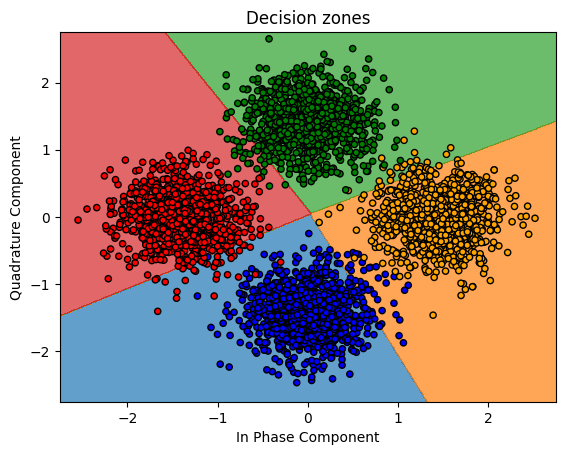

In [12]:
x_new, y_new = dyn.generate_samples(4 * num_examples, advance = False)

acc, conf = test_model(Kalman_Filter.obs_model, x_new, y_new)
print(f"Accuracy: {acc:.4f}")
print(f"Confidence: {conf:.4f}")
plot_decision_zones(Kalman_Filter.obs_model, x_new, y_new, 4)